<a href="https://colab.research.google.com/github/IHMilon/CNN-Image-Classification-Portfolio/blob/main/VGG11_CIFAR10/Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification with VGG-like Architecture**
---
In this project, I implement a **VGG-style CNN** from scratch and train it on the *CIFAR-10* dataset.  

- Dataset: CIFAR-10 (60,000 images, 10 classes, 32×32 pixels)  
- Model: Custom VGG-inspired architecture  
- Goal: Achieve high classification accuracy with proper training pipeline

## **Package Installation**

In [1]:
!pip install torchprofile 1>/dev/null

## **Import Dependencies**

In [2]:
import os
import random
import time
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
from PIL import Image


import torch
import torchvision
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

##  **Reproducibility**

In [3]:
seed_value = 10
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

## **Device Setup**

In [4]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(f"Device is : {device}")

Device is : cuda


## **Data Augmentation**
*To improve generalization, I apply some common image transformations to the CIFAR-10 training set. The test set is only converted to Tensor.*

In [5]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

## **Loading the CIFAR-10 Dataset**

We use the **torchvision's CIFAR-10 dataset** which contains **60,000 color images (32×32 pixels) across 10 classes**.

- **Training Set:** *50,000 images (with data augmentation)*
- **Test Set:** *10,000 images (for evaluation)*

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = train_transform)
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True, pin_memory = True)

test_data = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = test_transform)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False, pin_memory= True)

## **Inspect Training Batch**
*we can verify the data type and shape of the train loader*

In [7]:
for images, targets in train_loader:
    print(f"Images shape: {images.shape}, and dtype: {images.dtype}")
    print(f"Targets shape: {targets.shape}, and dtype: {targets.dtype}")
    break

Images shape: torch.Size([128, 3, 32, 32]), and dtype: torch.float32
Targets shape: torch.Size([128]), and dtype: torch.int64


## **Defining the Model**

We implement a **VGG-inspired CNN** where:
- **Backbone:** Composed of eight `conv-bn-relu` blocks interleaved with four `maxpool`'s to downsample the feature map by 2^4 = 16 times.

- **Classifier:** Uses **two fc (linear) layers** for final prediction.

In [8]:
class VGGM (nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.backbone = nn.Sequential(
              # Block 1
              nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(2), #(B,64,16,16)

              # Block 2
              nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.MaxPool2d(2),  #(B,128,8,8)

              # Block 3
              nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),
              nn.Conv2d(256, 256, kernel_size =3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),
              nn.MaxPool2d(2),  #(B,256,4,4)

              # Block 4
              nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(512),
              nn.ReLU(),
              nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(512),
              nn.ReLU(),
              nn.MaxPool2d(2)  #(B,512,2,2)
              )

        # Classifier
        self.classifier = nn.Sequential(
              nn.Linear(512, 128),
              nn.BatchNorm1d(128),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(128, 10)
              )

    def forward(self, x):
        # Backbone: (B, 3, 32, 32) --> (B, 512, 2, 2)
        x = self.backbone(x)

        # Avgpool: (B, 512, 2, 2) -->(B, 512)
        x = x.mean(dim=(2,3))

        # Classifier: (B, 512) --> (B, 10)
        x = self.classifier(x)
        return x

model = VGGM().to(device)

## **Model Size**
The model size can be estimated by the number of trainable parameters:

In [9]:
total_params = 0
for params in model.parameters():
    if params.requires_grad:
       total_params += params.numel()
print(f" Total Parameters is: {total_params/1000000:.2f} Millon")

 Total Parameters is: 4.76 Millon


## **Computational Cost**

The computation cost can be estimated by the number of multiply–accumulate operations (MACs):

In [10]:
x = torch.ones(1, 3, 32, 32).to(device)
model.eval() # Set the model to evaluation mode
macs = profile_macs(model, x)
print(f"Total number of MACs is: {macs/1000000:.2f} Million")

Total number of MACs is: 209.70 Million


## **Training Setup**
We use `CrossEntropyLoss` as the loss function, `AdamW` optimizer with weight decay for regularization, and the `OneCycleLR` scheduler for dynamic learning rate adjustment.
Also Training is performed with `mixed precision` to accelerate computations and reduce GPU memory usage, following best practices in modern deep learning workflows.

In [19]:
Epochs = 2

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 5e-4)

# LR Scheduler (OneCycleLR)
scheduler = OneCycleLR(optimizer,
            max_lr = 0.01,
            steps_per_epoch = len(train_loader),
            epochs = Epochs
            )

# Initialize the scaler
scaler = GradScaler('cuda')

## **Model Training**

The VGG-like network is trained on **CIFAR-10** using **mixed precision** (`torch.amp`) for efficiency.  
Each epoch includes:  

- Forward pass with automatic loss scaling  
- Backpropagation
- Optimizer updates with learning rate scheduling  
- Validation after each epoch to monitor generalization.

In [20]:
train_losses, train_accs = [], []
test_losses, test_accs =[], []

# Getting training time
start_time = time.time()

for epoch in tqdm(range(1, Epochs+1), desc = "Epochs"):

    # Training loop
    model.train()

    # Training matrices
    train_loss = 0
    num_samples = 0
    num_correct = 0

    for images, labels in train_loader:
        # Move data to the GPU
        images, labels = images.to(device), labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # scale the loss and calculate the gradiants
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update the learning rate after each batch
        scheduler.step()

        # convert logits to class indices
        predictions = outputs.argmax(dim=1)

        # update the training matrices
        train_loss += loss.item()
        num_samples += labels.size(0)
        num_correct += (predictions == labels).sum().item()

    # training accuracy and losses
    train_acc = (num_correct/num_samples)*100
    train_losses.append(train_loss/len(train_loader))
    train_accs.append(train_acc)


    # validation loop
    model.eval()

    # test matrices
    test_loss = 0
    test_samples = 0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion (outputs, labels)

            # Convert logits to class indecies
            predictions = outputs.argmax(dim=1)

            # update test matrices
            test_loss += loss.item()
            test_samples += labels.size(0)
            test_correct += (predictions == labels).sum().item()

        # Testing Accuracies and losses
        test_acc = (test_correct / test_samples)*100
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(test_acc)

# Final model performance matrices
print(f"Training loss {train_losses[-1]:.3f}, Train Accuracy {train_accs[-1]:.2f}%")
print(f"Test loss { test_losses[-1]:.3f}, Test Accuracy {test_accs[-1]:.2f}%")

# Calculate the Training Time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time to train the model is {(total_time/60):.2f} Minutes")

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training loss 0.253, Train Accuracy 91.58%
Test loss 0.273, Test Accuracy 91.38%

Total time to train the model is 0.99 Minutes


## **Training & Validation Loss/Accuracy**

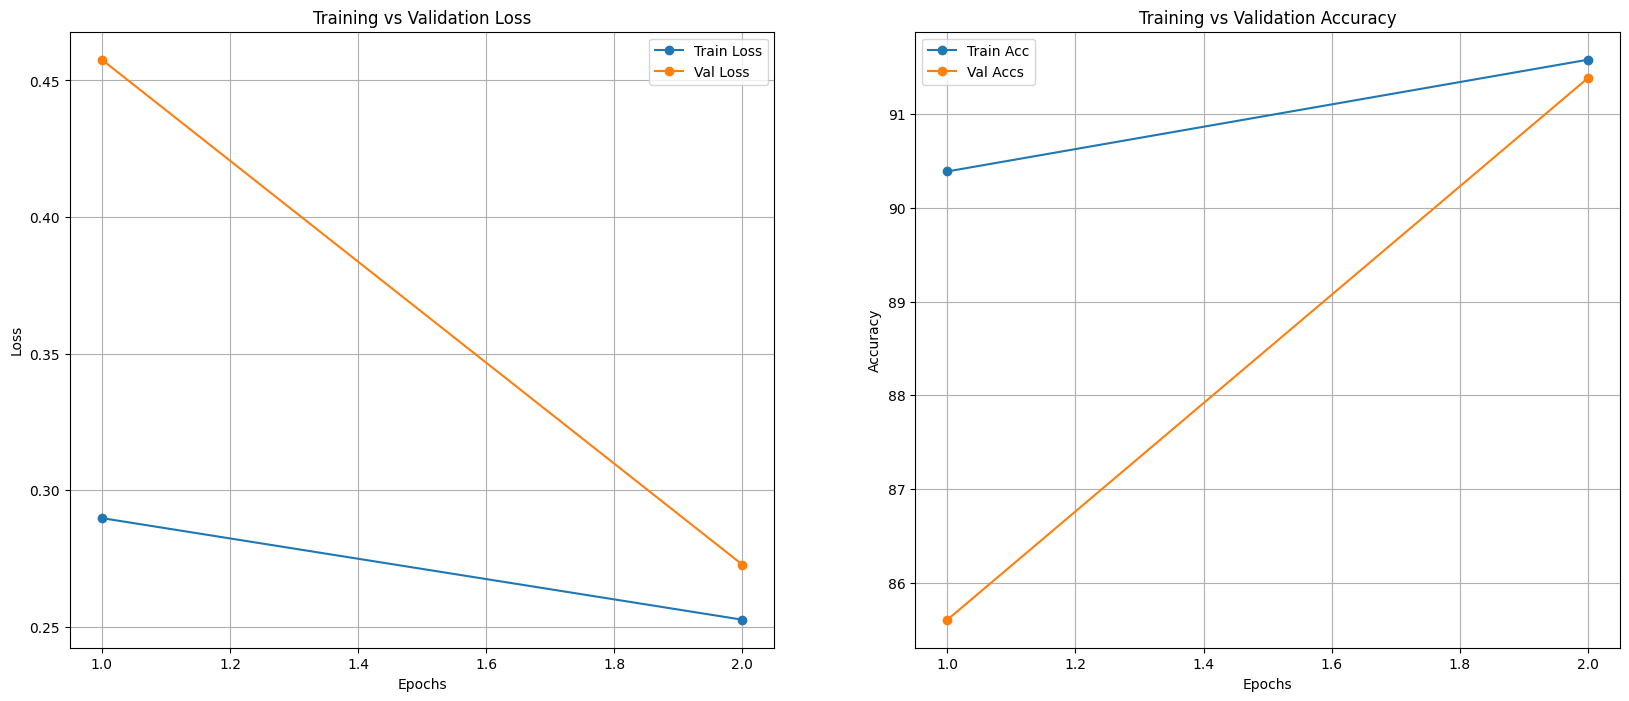

In [21]:
epoch_range = range(1,Epochs+1)
plt.figure(figsize=(20,8))

# Plot the Train and Val loss
plt.subplot(1,2,1)
plt.plot(epoch_range, train_losses, label = "Train Loss",marker='o')
plt.plot(epoch_range, test_losses, label = "Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot the Train and Val Accuracy
plt.subplot(1,2,2)
plt.plot(epoch_range, train_accs, label = "Train Acc",marker='o')
plt.plot(epoch_range, test_accs, label = "Val Accs",marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## **Visualization**
We can visualize the model's prediction to see how the model truly performs:

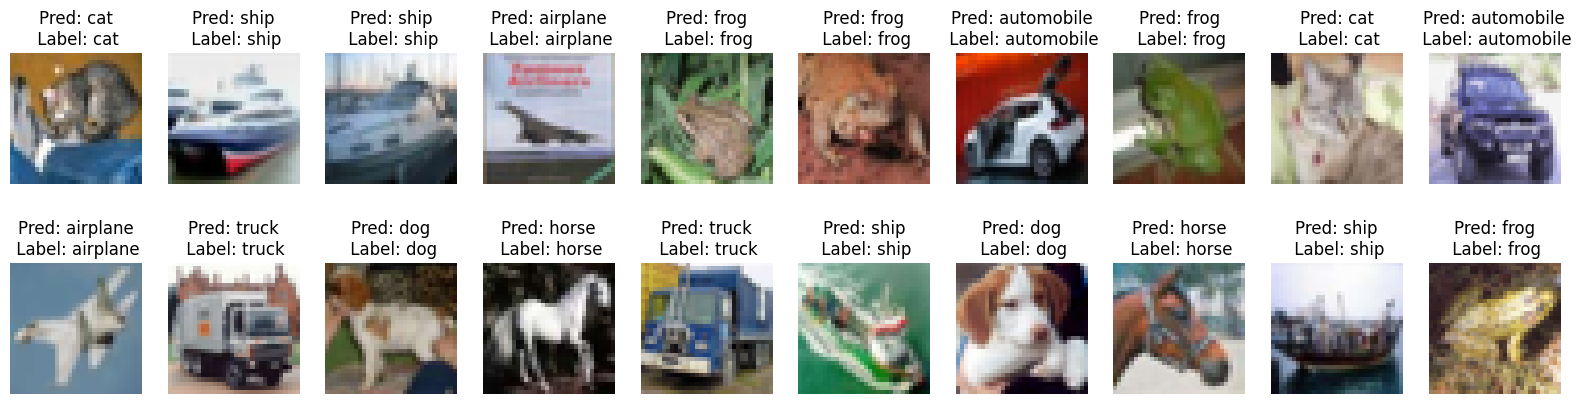

In [17]:
plt.figure(figsize=(20,5))

for i in range(20):
    image, label = test_data[i]

    # Model inference
    model.eval()
    with torch.inference_mode():
         pred = model(image.unsqueeze(dim=0).to(device))
         pred = pred.argmax(dim = 1)

    # Convert CHW to HWC for visualization
    image = image.permute(1,2,0)

    # Convert class label to class name
    label = test_data.classes[label]
    pred = test_data.classes[pred]

    # Visualize the images
    plt.subplot(2, 10, i+1)
    plt.imshow(image)
    plt.title(f"Pred: {pred}"+ "\n" + f" Label: {label}")
    plt.axis('off')
plt.show()

## **Confusion Matrix**
It visualizes the model's performance on the testset. And helps to identify which classes the model confuses the most.

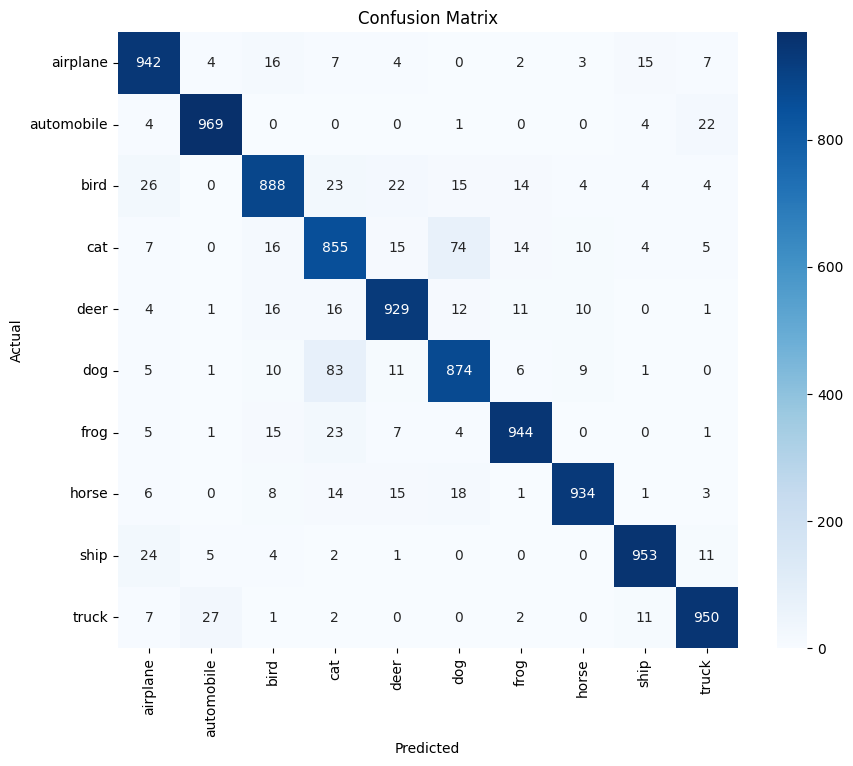

In [18]:
# Collect predictions and true labels
true_labels = []
predictions = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

# Compute confusion matrix
matrix = confusion_matrix(true_labels, predictions)

# Get class name from label index
class_name = test_data.classes

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_name, yticklabels=class_name, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()